# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# 1. Importing data

In [30]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import time
import matplotlib.pyplot as plt
% matplotlib inline

In [31]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [32]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)
print(profile.shape)
profile.head()

(17000, 5)


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [33]:
# data/JSON_to_CSV.ipynb converted transcript.json to transcript.csv, so that I don't
# need to run 'conda update pandas' in the terminal every time I start the workspace
transcript = pd.read_csv('data/transcript.csv')
print(transcript.shape)
transcript.head()

(306534, 5)


,Unnamed: 0,event,person,time,value
0,0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# 2. Data processing and exploration

## 2.1 Process Portfolio

The long **id** for each offer is replaced with a simple number **o_id** for easy identification in later analysis. The duration in hours is also caculated to be used in later analysis.

In [34]:
portfolio['valid_hours'] = portfolio['duration'] * 24
portfolio['o_id'] = (portfolio.index + 1).astype(str)
portfolio

,channels,difficulty,duration,id,offer_type,reward,valid_hours,o_id
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,168,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,120,2
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,96,3
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,168,4
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,240,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,168,6
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,240,7
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,72,8
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,120,9
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,168,10


In [35]:
portfolio.describe()

,difficulty,duration,reward,valid_hours
count,10.000000,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000,156.000000
std,5.831905,2.321398,3.583915,55.713553
min,0.000000,3.000000,0.000000,72.000000
25%,5.000000,5.000000,2.000000,120.000000
50%,8.500000,7.000000,4.000000,168.000000
75%,10.000000,7.000000,5.000000,168.000000
max,20.000000,10.000000,10.000000,240.000000


In [36]:
offer_id = portfolio[['id', 'o_id']]
offer_id = offer_id.set_index('id')['o_id']
offer_id

id
ae264e3637204a6fb9bb56bc8210ddfd     1
4d5c57ea9a6940dd891ad53e9dbe8da0     2
3f207df678b143eea3cee63160fa8bed     3
9b98b8c7a33c4b65b9aebfe6a799e6d9     4
0b1e1539f2cc45b7b9fa7c272da2e1d7     5
2298d6c36e964ae4a3e7e9706d1fb8c2     6
fafdcd668e3743c1bb461111dcafc2a4     7
5a8bc65990b245e5a138643cd4eb9837     8
f19421c1d4aa40978ebb69ca19b0e20d     9
2906b810c7d4411798c6938adc9daaa5    10
Name: o_id, dtype: object

In [37]:
offer_expire = portfolio[['o_id', 'valid_hours']]
offer_expire = offer_expire.set_index('o_id')['valid_hours']
offer_expire

o_id
1     168
2     120
3      96
4     168
5     240
6     168
7     240
8      72
9     120
10    168
Name: valid_hours, dtype: int64

## 2.2 Process Customer Profile

### 2.2.1 Cleaning abnormalities, null values and duplicates

We noticed some abnormalities in customer profile data. There are 2175 entries with age = 118. According to Wikipedia: https://en.wikipedia.org/wiki/List_of_the_verified_oldest_people, the current oldest living person is 116 years old. Also, all these entries have no information for gender and income. Considering those data entries will not provide any value to our analysis, we decide to delete those entries from Profile data. 

In [38]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [39]:
age118 = profile[profile['age'] == 118]
age118.shape

(2175, 5)

In [40]:
age118['gender'].value_counts()

Series([], Name: gender, dtype: int64)

In [41]:
age118['income'].value_counts()

Series([], Name: income, dtype: int64)

In [42]:
profile = profile[profile['age'] != 118]
profile.shape

(14825, 5)

In [43]:
profile.isnull().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [44]:
profile.duplicated().sum()

0

### 2.2.2 Calculate membership history in months

In [45]:
current = pd.to_datetime(np.datetime64("2018-12-28"))
current

Timestamp('2018-12-28 00:00:00')

In [46]:
member_date = pd.to_datetime(profile['became_member_on'], format="%Y%m%d")
profile['member_months'] = (current - member_date)/np.timedelta64(1, 'M')
profile['member_months'] = profile['member_months'].astype(int)

In [47]:
profile.duplicated().sum()

0

### 2.2.3. Replace long customer id with short id
Replace long customer **id** with a short simple number **c_id** for easy identification in later analysis.

In [48]:
profile['c_id'] = profile.index.astype(str)

In [49]:
profile.head()

,age,became_member_on,gender,id,income,member_months,c_id
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,17,1
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,19,3
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,8,5
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,10,8
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,13,12


In [50]:
person_id = profile[['id', 'c_id']]
person_id = person_id.set_index('id')['c_id']


### 2.2.4 Customer Distributions
Visualize customer distributions by **gender**, **age**, **income** and **member_months** and divide the customers into groups based on these characteristics. 

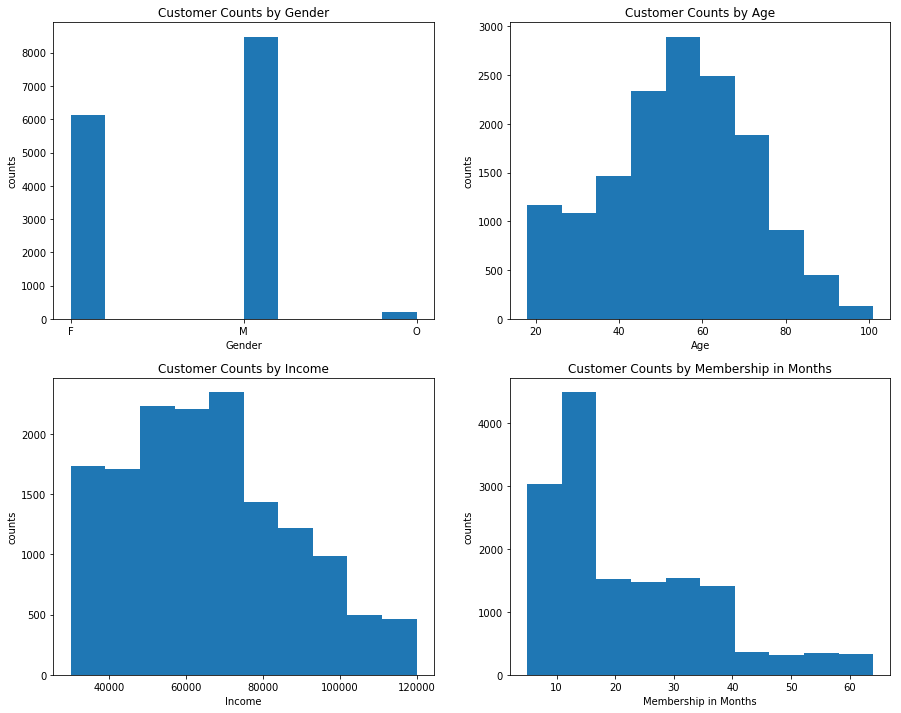

In [51]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.hist(profile['gender']);
ax1.set_xlabel('Gender');
ax1.set_ylabel('counts');
ax1.set_title('Customer Counts by Gender');

ax2.hist(profile['age']);
ax2.set_xlabel('Age');
ax2.set_ylabel('counts');
ax2.set_title('Customer Counts by Age');

ax3.hist(profile['income']);
ax3.set_xlabel('Income');
ax3.set_ylabel('counts');
ax3.set_title('Customer Counts by Income');

ax4.hist(profile['member_months']);
ax4.set_xlabel('Membership in Months');
ax4.set_ylabel('counts');
ax4.set_title('Customer Counts by Membership in Months');

plt.show()

In [52]:
age_bin = [0, 40, 70, 120]
age_labels = ['age:<=40', 'age:41-70', 'age:>=71']
age_group = pd.cut(profile['age'], bins = age_bin, labels = age_labels)
age_group.head()

1     age:41-70
3      age:>=71
5     age:41-70
8     age:41-70
12    age:41-70
Name: age, dtype: category
Categories (3, object): [age:<=40 < age:41-70 < age:>=71]

In [53]:
income_bin = [0, 50000, 80000, 1000000]
income_labels = ['income:<=50000', 'income:50001_to_80000', 'income:>=80001']
income_group = pd.cut(profile['income'], bins = income_bin, labels = income_labels)
income_group.head()

1            income:>=80001
3            income:>=80001
5     income:50001_to_80000
8     income:50001_to_80000
12    income:50001_to_80000
Name: income, dtype: category
Categories (3, object): [income:<=50000 < income:50001_to_80000 < income:>=80001]

In [54]:
membership_bin = [0, 12, 36, 1000]
membership_labels = ['member:<=1_year', 'member:1_to_3_years', 'member:>3_years']
membership_group = pd.cut(profile['member_months'], bins = membership_bin, labels = membership_labels)
membership_group.head()

1     member:1_to_3_years
3     member:1_to_3_years
5         member:<=1_year
8         member:<=1_year
12    member:1_to_3_years
Name: member_months, dtype: category
Categories (3, object): [member:<=1_year < member:1_to_3_years < member:>3_years]

In [55]:
#combine into one-hot encoded customer data
profile_desc = pd.concat([profile[['c_id', 'gender']], age_group, income_group, membership_group], axis = 1)
profile_desc.head()

,c_id,gender,age,income,member_months
1,1,F,age:41-70,income:>=80001,member:1_to_3_years
3,3,F,age:>=71,income:>=80001,member:1_to_3_years
5,5,M,age:41-70,income:50001_to_80000,member:<=1_year
8,8,M,age:41-70,income:50001_to_80000,member:<=1_year
12,12,M,age:41-70,income:50001_to_80000,member:1_to_3_years


## 2.3 Process Transcript Data

In [56]:
transcript.describe()

,Unnamed: 0,time
count,306534.000000,306534.000000
mean,153266.500000,366.382940
std,88488.888045,200.326314
min,0.000000,0.000000
25%,76633.250000,186.000000
50%,153266.500000,408.000000
75%,229899.750000,528.000000
max,306533.000000,714.000000


### 2.3.1. Select Transcript Data Related to Offer Activities
In this analysis, our focus is the percentage of viewed and completed offers per offer type for different customer groups, so we don't need other transaction records.

In [57]:
transcript.shape

(306534, 5)

In [58]:
transcript.head()

,Unnamed: 0,event,person,time,value
0,0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [59]:
transcript['person'] = transcript['person'].map(person_id)
#transcript['offer_id'] = offer_trans['offer_id'].map(offer_id)
transcript = transcript.rename(columns = {'offer_id': 'o_id', 'person': 'c_id'})
transcript.head()

,Unnamed: 0,event,c_id,time,value
0,0,offer received,3,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,1,offer received,NaN,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,2,offer received,5,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,3,offer received,NaN,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,4,offer received,NaN,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [60]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [61]:
offer_trans = transcript[transcript['event'] != 'transaction']
offer_trans.head()

,Unnamed: 0,event,c_id,time,value
0,0,offer received,3,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,1,offer received,NaN,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,2,offer received,5,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,3,offer received,NaN,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,4,offer received,NaN,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


### 2.3.2 Extract offer_id from value field and replace customer id and offer id with c_id and o_id

In [62]:
offer_trans['offer_id'] = offer_trans['value'].str.extract(r'{\'offer.id\': \'([0-9A-Fa-f]+)\'.*}')
offer_trans

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,event,c_id,time,value,offer_id
0,0,offer received,3,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,1,offer received,NaN,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,2,offer received,5,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,3,offer received,NaN,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,4,offer received,NaN,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0
5,5,offer received,8,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
6,6,offer received,NaN,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2
7,7,offer received,12,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
8,8,offer received,13,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
9,9,offer received,15,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7


In [63]:
#offer_trans['person'] = offer_trans['person'].map(person_id)
offer_trans['offer_id'] = offer_trans['offer_id'].map(offer_id)
offer_trans = offer_trans.rename(columns = {'offer_id': 'o_id', 'person': 'c_id'})
offer_trans.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Unnamed: 0,event,c_id,time,value,o_id
0,0,offer received,3,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},4
1,1,offer received,NaN,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},5
2,2,offer received,5,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},10
3,3,offer received,NaN,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},7
4,4,offer received,NaN,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},2


### 2.3.3 Data validation
Some customers in offer transcript are not in customer profile.Delete those rows since there's no customer data to analyze. It's about 11% rows.

In [64]:
offer_trans['c_id'].isnull().sum()

18776

In [65]:
offer_trans.shape

(167581, 6)

In [66]:
18776/167581

0.11204134120216493

In [67]:
#Some customers in offer transcript are not in customer profile.
#Delete those rows since there's no customer data to analyze. It's about 11% rows.
offer_trans = offer_trans[np.logical_not(offer_trans['c_id'].isnull())]
offer_trans['c_id'].isnull().sum()

0

# 3.  Data Analyzing and Visualization

## 3.1 Combine profile data with offer transactions

In [68]:
offer_trans = offer_trans.merge(profile_desc, how ='left', on='c_id')
offer_trans = offer_trans.drop(['value'], axis=1)
offer_trans.head()

,Unnamed: 0,event,c_id,time,o_id,gender,age,income,member_months
0,0,offer received,3,0,4,F,age:>=71,income:>=80001,member:1_to_3_years
1,2,offer received,5,0,10,M,age:41-70,income:50001_to_80000,member:<=1_year
2,5,offer received,8,0,9,M,age:41-70,income:50001_to_80000,member:<=1_year
3,7,offer received,12,0,3,M,age:41-70,income:50001_to_80000,member:1_to_3_years
4,8,offer received,13,0,5,F,age:41-70,income:50001_to_80000,member:1_to_3_years


In [69]:
offer_trans.shape

(148805, 9)

In [70]:
offer_received = offer_trans[offer_trans['event'] == 'offer received']
offer_received.shape

(66501, 9)

In [71]:
offer_viewed = offer_trans[offer_trans['event'] == 'offer viewed']
offer_viewed.shape

(49860, 9)

In [72]:
offer_completed= offer_trans[offer_trans['event'] == 'offer completed']
offer_completed.shape

(32444, 9)

## 3.2 Calculate viewed status and completed status for each received offer

In [73]:
# Add expiration time for offers
offer_received['expire_time'] = offer_received['o_id']
offer_received['expire_time'] = offer_received['o_id'].map(offer_expire)
offer_received['expire_time'] = offer_received['expire_time'] + offer_received['time']
offer_received.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,Unnamed: 0,event,c_id,time,o_id,gender,age,income,member_months,expire_time
0,0,offer received,3,0,4,F,age:>=71,income:>=80001,member:1_to_3_years,168
1,2,offer received,5,0,10,M,age:41-70,income:50001_to_80000,member:<=1_year,168
2,5,offer received,8,0,9,M,age:41-70,income:50001_to_80000,member:<=1_year,120
3,7,offer received,12,0,3,M,age:41-70,income:50001_to_80000,member:1_to_3_years,96
4,8,offer received,13,0,5,F,age:41-70,income:50001_to_80000,member:1_to_3_years,240


In [74]:
#compute completion status and viewed status for offers
offer_completed_group = offer_completed.groupby(['c_id','o_id'])
offer_viewed_group = offer_viewed.groupby(['c_id','o_id'])

def offer_match(row, group_to_match):
    if( (row['c_id'], row['o_id']) in group_to_match.groups.keys()):
        matched_offers = group_to_match.get_group((row['c_id'], row['o_id']))
        if (np.logical_and(matched_offers['time'] >= row['time'], 
                           matched_offers['time'] < row['expire_time'])).any():
            return True
        else:
            return False
    else:
        return False

In [75]:
time0 = time.time()
offer_received['complete'] = offer_received.apply(lambda row: offer_match(row, offer_completed_group),axis=1)
time1 = time.time()
offer_received.tail(15)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Unnamed: 0,event,c_id,time,o_id,gender,age,income,member_months,expire_time,complete
132364,257871,offer received,16981,576,9,M,age:>=71,income:>=80001,member:1_to_3_years,696,True
132365,257872,offer received,16983,576,5,F,age:>=71,income:50001_to_80000,member:>3_years,816,False
132366,257873,offer received,16984,576,1,F,age:>=71,income:50001_to_80000,member:1_to_3_years,744,True
132367,257874,offer received,16985,576,4,M,age:<=40,income:50001_to_80000,member:<=1_year,744,False
132368,257875,offer received,16986,576,5,F,age:41-70,income:50001_to_80000,member:1_to_3_years,816,False
132369,257876,offer received,16987,576,4,M,age:41-70,income:<=50000,member:1_to_3_years,744,False
132370,257877,offer received,16988,576,4,M,age:41-70,income:50001_to_80000,member:<=1_year,744,True
132371,257879,offer received,6829,576,5,M,age:<=40,income:<=50000,member:1_to_3_years,816,True
132372,257880,offer received,12962,576,8,M,age:41-70,income:>=80001,member:1_to_3_years,648,False
132373,257881,offer received,14217,576,8,M,age:41-70,income:50001_to_80000,member:<=1_year,648,False


In [76]:
print(time1-time0)

46.669387102127075


In [77]:
time0 = time.time()
offer_received['viewed'] = offer_received.apply(lambda row: offer_match(row, offer_viewed_group),axis=1)
time1 = time.time()
offer_received.tail(15)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Unnamed: 0,event,c_id,time,o_id,gender,age,income,member_months,expire_time,complete,viewed
132364,257871,offer received,16981,576,9,M,age:>=71,income:>=80001,member:1_to_3_years,696,True,True
132365,257872,offer received,16983,576,5,F,age:>=71,income:50001_to_80000,member:>3_years,816,False,False
132366,257873,offer received,16984,576,1,F,age:>=71,income:50001_to_80000,member:1_to_3_years,744,True,True
132367,257874,offer received,16985,576,4,M,age:<=40,income:50001_to_80000,member:<=1_year,744,False,False
132368,257875,offer received,16986,576,5,F,age:41-70,income:50001_to_80000,member:1_to_3_years,816,False,False
132369,257876,offer received,16987,576,4,M,age:41-70,income:<=50000,member:1_to_3_years,744,False,True
132370,257877,offer received,16988,576,4,M,age:41-70,income:50001_to_80000,member:<=1_year,744,True,False
132371,257879,offer received,6829,576,5,M,age:<=40,income:<=50000,member:1_to_3_years,816,True,True
132372,257880,offer received,12962,576,8,M,age:41-70,income:>=80001,member:1_to_3_years,648,False,True
132373,257881,offer received,14217,576,8,M,age:41-70,income:50001_to_80000,member:<=1_year,648,False,True


In [78]:
print(time1-time0)

69.79572558403015


## 3.3 Data Validation
The offers that can be identified as viewed or complete are less than (about 4%) the real number of completed or viewed offers. Accuracy is not 100%
In real world cases, a better way should be found as to how to identify viewed and completed offers by talking to the data provider.

In [79]:
offer_received[offer_received['complete'] == True].shape

(32088, 12)

In [80]:
offer_received[offer_received['viewed'] == True].shape

(48914, 12)

In [81]:
offer_completed.shape

(32444, 9)

In [82]:
offer_viewed.shape

(49860, 9)

## 3.4 Visualization

### 3.4.1 Offer Distribution

In [83]:
#offer 3 and offer 8 are informational offers.
#there's no record of offer being completed for informational offers.
#We need to add rows with 0 for these types of offers.
def sort_counts(count_series):
    count_series.index = count_series.index.astype(int)
    if len(count_series) < 10:
        for i in range(1, 11):
            if i not in count_series.index.values:
                count_series = count_series.append(pd.Series([0], index=[i]))
            
    count_series = count_series.sort_index()
    #count_series.index = count_series.index.astype(str, copy = False)
    return count_series

received_counts = sort_counts(offer_received['o_id'].value_counts())
viewed_counts = sort_counts(offer_received[offer_received['viewed'] == True]['o_id'].value_counts())
complete_counts = sort_counts(offer_received[offer_received['complete'] == True]['o_id'].value_counts())


In [84]:
#offer 3 and offer 8 are informational offers.
#there's no record of offer being completed for informational offers.
#We need to add rows with 0 for these types of offers.
complete_counts


1     3614
2     3246
3        0
4     4139
5     3367
6     4845
7     4996
8        0
9     4021
10    3860
dtype: int64

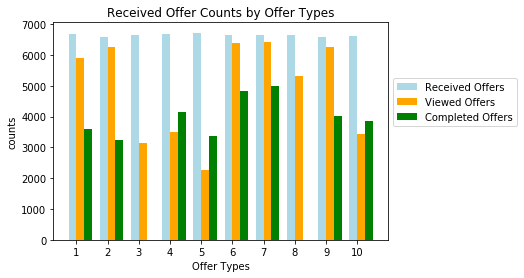

In [85]:


fig, ax = plt.subplots()
ind = np.arange(len(received_counts))                # the x locations for the groups
width = 0.25                                  # the width of the bars

p1 = ax.bar(ind, received_counts, width, color='lightblue', bottom=0)
p2 = ax.bar(ind + width, viewed_counts, width, color='orange', bottom=0)
p3 = ax.bar(ind + 2*width, complete_counts, width, color='green', bottom=0)

ax.set_xlabel('Offer Types');
ax.set_ylabel('counts');
ax.set_title('Received Offer Counts by Offer Types')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))

ax.legend((p1[0], p2[0], p3[0]), ('Received Offers', 'Viewed Offers', 'Completed Offers'), 
          loc='lower left', bbox_to_anchor=(1, 0.5))

plt.show()

### 3.4.2  Heatmaps of viewed percentage of each offer type by customer groups

In [86]:
import seaborn as sns
def heatmap_grid(df, row, col, field):
    col_values = list(df[col].unique())
    grid_list = []
    for col_value in col_values:
        col_group = df[df[col] == col_value]
        row_col_percent = col_group.groupby(row)[field].sum()/col_group.groupby(row).size()
        grid_list.append(row_col_percent)
    grid = pd.concat(grid_list, axis = 1)
    grid.columns = col_values
    return grid

heatmap_grid(offer_received, 'o_id', 'age', 'viewed')

,age:>=71,age:41-70,age:<=40
o_id,,,
1,0.875110,0.856119,0.956696
10,0.521968,0.567629,0.393236
2,0.952096,0.951755,0.946075
3,0.490504,0.514264,0.346801
4,0.544695,0.557114,0.414439
5,0.350168,0.380184,0.217075
6,0.964987,0.959726,0.956380
7,0.969775,0.967250,0.963186
8,0.755833,0.776833,0.893499


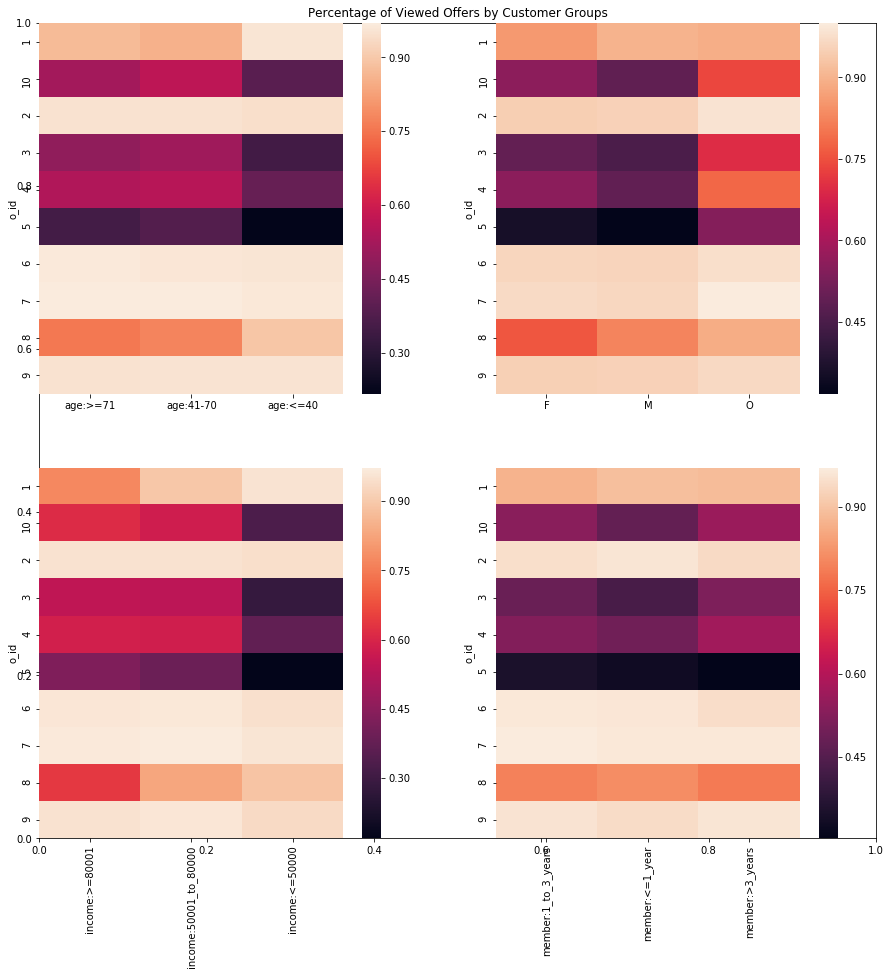

In [91]:
fig = plt.figure(figsize=(15,15))
plt.title("Percentage of Viewed Offers by Customer Groups")
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

sns.heatmap(heatmap_grid(offer_received, 'o_id', 'age', 'viewed'), ax = ax1)
sns.heatmap(heatmap_grid(offer_received, 'o_id', 'gender', 'viewed'), ax = ax2)
sns.heatmap(heatmap_grid(offer_received, 'o_id', 'income', 'viewed'), ax = ax3)
sns.heatmap(heatmap_grid(offer_received, 'o_id', 'member_months', 'viewed'), ax = ax4)

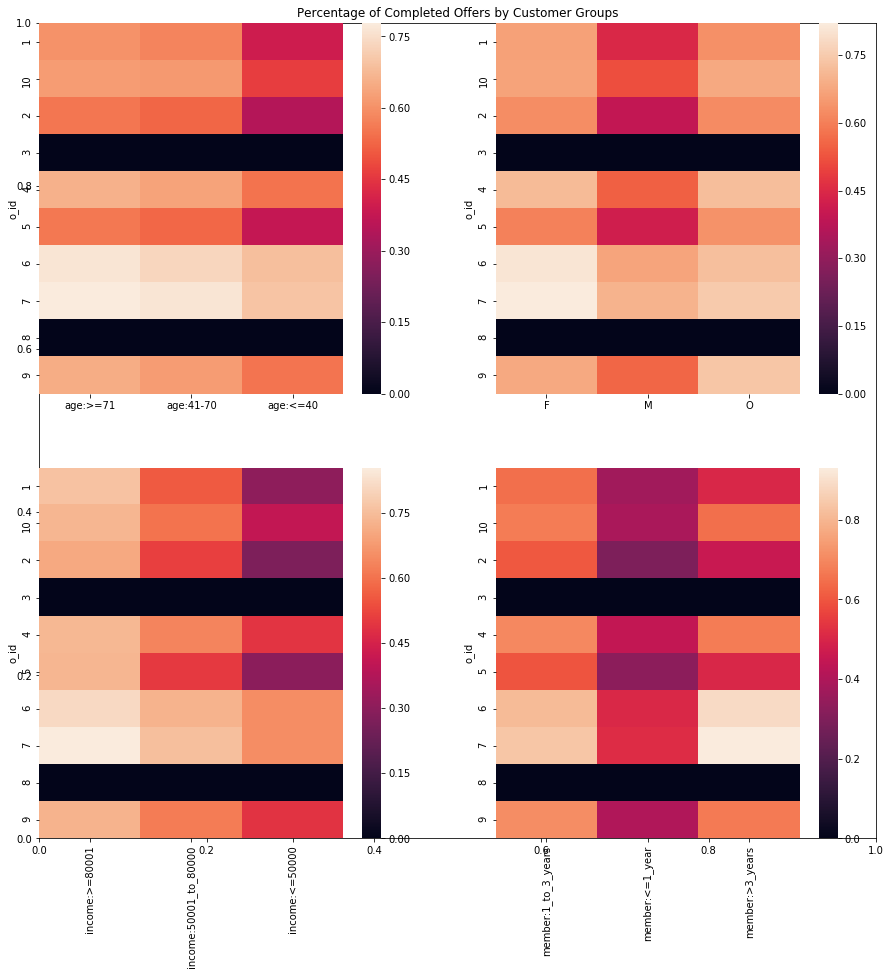

In [92]:
fig = plt.figure(figsize=(15,15))
plt.title("Percentage of Completed Offers by Customer Groups")
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

sns.heatmap(heatmap_grid(offer_received, 'o_id', 'age', 'complete'), ax = ax1)
sns.heatmap(heatmap_grid(offer_received, 'o_id', 'gender', 'complete'), ax = ax2)
sns.heatmap(heatmap_grid(offer_received, 'o_id', 'income', 'complete'), ax = ax3)
sns.heatmap(heatmap_grid(offer_received, 'o_id', 'member_months', 'complete'), ax = ax4)

### 3.4.3 Calculate tables to provide heuristics

In [93]:
offer_groups = offer_received.groupby(['gender','age', 'income', 'member_months', 'o_id'])
offer_groups_viewed = (offer_groups['viewed'].sum()/offer_groups.size()).rename('view_percent')
offer_groups_viewed = pd.concat([offer_groups_viewed, offer_groups.size().rename('count')], axis = 1).reset_index()
offer_groups_viewed.shape

(748, 7)

In [95]:
offer_groups_complete = (offer_groups['complete'].sum()/offer_groups.size()).rename('complete_percent')
offer_groups_complete = pd.concat([offer_groups_complete, offer_groups.size().rename('count')], axis = 1).reset_index()
offer_groups_complete.shape

(748, 7)

In [98]:
offer_groups_stats = pd.merge(offer_groups_viewed, offer_groups_complete, 
                              how = 'inner', on = ['gender','age', 'income', 'member_months', 'o_id', 'count'])
offer_groups_stats.head()

,gender,age,income,member_months,o_id,view_percent,count,complete_percent
0,F,age:<=40,income:<=50000,member:<=1_year,1,0.926471,68,0.367647
1,F,age:<=40,income:<=50000,member:<=1_year,10,0.458333,48,0.375000
2,F,age:<=40,income:<=50000,member:<=1_year,2,0.959184,49,0.306122
3,F,age:<=40,income:<=50000,member:<=1_year,3,0.375000,56,0.000000
4,F,age:<=40,income:<=50000,member:<=1_year,4,0.520000,50,0.540000


In [100]:
offer_groups_stats[(offer_groups_stats['gender'] == 'F') & 
                    (offer_groups_stats['age'] == 'age:41-70') & 
                    (offer_groups_stats['income'] == 'income:50001_to_80000') &
                    (offer_groups_stats['member_months'] == 'member:1_to_3_years')].sort_values(by=['complete_percent'], ascending = False)

,gender,age,income,member_months,o_id,view_percent,count,complete_percent
136,F,age:41-70,income:50001_to_80000,member:1_to_3_years,7,0.978723,470,0.900000
135,F,age:41-70,income:50001_to_80000,member:1_to_3_years,6,0.980159,504,0.837302
133,F,age:41-70,income:50001_to_80000,member:1_to_3_years,4,0.705882,425,0.804706
130,F,age:41-70,income:50001_to_80000,member:1_to_3_years,10,0.686275,459,0.779956
129,F,age:41-70,income:50001_to_80000,member:1_to_3_years,1,0.841860,430,0.774419
131,F,age:41-70,income:50001_to_80000,member:1_to_3_years,2,0.956522,460,0.747826
138,F,age:41-70,income:50001_to_80000,member:1_to_3_years,9,0.966102,472,0.741525
134,F,age:41-70,income:50001_to_80000,member:1_to_3_years,5,0.465409,477,0.672956
132,F,age:41-70,income:50001_to_80000,member:1_to_3_years,3,0.638996,518,0.000000
137,F,age:41-70,income:50001_to_80000,member:1_to_3_years,8,0.823529,459,0.000000


## Customers who are not influenced by offers

In [72]:
transactions = transcript[transcript['event'] == 'transaction']

In [73]:
transactions['c_id'].isnull().sum()

14996

In [74]:
transactions = transactions[np.logical_not(transactions['c_id'].isnull())]
transactions['c_id'].isnull().sum()

0

In [75]:
transactions.head()

,Unnamed: 0,event,c_id,time,value
12654,12654,transaction,41,0,{'amount': 0.8300000000000001}
12657,12657,transaction,55,0,{'amount': 34.56}
12659,12659,transaction,63,0,{'amount': 13.23}
12670,12670,transaction,134,0,{'amount': 19.51}
12671,12671,transaction,151,0,{'amount': 18.97}


In [76]:
offers_customer_groups = offer_received.groupby(['c_id'])
def influenced_by_offer(row, offers_customer_groups):
    if( row['c_id'] in offers_customer_groups.groups.keys()):
        offers_same_customer = offers_customer_groups.get_group(row['c_id'])
        offers_timely = offers_same_customer[(row['time'] >= offers_same_customer['time']) & 
                                         ( row['time'] < offers_same_customer['expire_time'])]
        if (offers_timely.shape[0] > 0) and (offers_timely['viewed'] == True).any():       
            return True
        else:
            return False
    else:
        return False


In [77]:
transactions.loc[12654,]

Unnamed: 0                             12654
event                            transaction
c_id                                      41
time                                       0
value         {'amount': 0.8300000000000001}
Name: 12654, dtype: object

In [78]:
influenced_by_offer(transactions.loc[12654,], offers_customer_groups)

True

In [79]:
time0 = time.time()
transactions['influenced'] = transactions.apply(lambda row: influenced_by_offer(row, offers_customer_groups), axis = 1)
time1 = time.time()
transactions

,Unnamed: 0,event,c_id,time,value,influenced
12654,12654,transaction,41,0,{'amount': 0.8300000000000001},True
12657,12657,transaction,55,0,{'amount': 34.56},True
12659,12659,transaction,63,0,{'amount': 13.23},False
12670,12670,transaction,134,0,{'amount': 19.51},True
12671,12671,transaction,151,0,{'amount': 18.97},True
12678,12678,transaction,174,0,{'amount': 33.9},True
12687,12687,transaction,257,0,{'amount': 18.59},False
12691,12691,transaction,299,0,{'amount': 18.01},True
12696,12696,transaction,316,0,{'amount': 19.11},True
12706,12706,transaction,392,0,{'amount': 36.19},True


In [80]:
print(time1-time0)

353.86759328842163


In [123]:
trans_customers = pd.merge(transactions['c_id'].to_frame(), profile_desc, how ='left', on='c_id')
print(trans_customers.shape)
trans_customers = trans_customers.groupby(['gender','age', 'income', 'member_months']).size()
trans_customers = trans_customers.rename('total_count').reset_index().sort_values('total_count', ascending = False)

(123957, 5)


In [111]:
non_offer_trans = transactions[transactions['influenced'] == False]
non_offer_customers = pd.merge(non_offer_trans['c_id'].to_frame(), profile_desc, how ='left', on='c_id')
print(non_offer_trans.shape)
non_offer_customers = non_offer_customers.groupby(['gender','age', 'income', 'member_months']).size()
non_offer_customers = non_offer_customers.rename('non_offer_count').reset_index().sort_values('non_offer_count', ascending = False)

(27202, 6)


In [124]:
trans_customers = pd.merge(trans_customers, non_offer_customers,
                          how = 'left', on = ['gender','age', 'income', 'member_months'])
trans_customers.isnull().sum()

gender             0
age                0
income             0
member_months      0
total_count        0
non_offer_count    1
dtype: int64

In [125]:
trans_customers['non_offer_count'] = trans_customers['non_offer_count'].fillna(0)
trans_customers['non_offer_percent'] = trans_customers['non_offer_count']/trans_customers['total_count']


In [127]:
trans_customers.sort_values('non_offer_percent', ascending = False)

,gender,age,income,member_months,total_count,non_offer_count,non_offer_percent
74,O,age:>=71,income:<=50000,member:<=1_year,19,9.0,0.473684
61,O,age:41-70,income:50001_to_80000,member:<=1_year,61,26.0,0.426230
56,O,age:<=40,income:50001_to_80000,member:1_to_3_years,99,36.0,0.363636
36,M,age:41-70,income:>=80001,member:<=1_year,948,339.0,0.357595
73,O,age:41-70,income:>=80001,member:<=1_year,26,9.0,0.346154
42,F,age:>=71,income:>=80001,member:<=1_year,574,194.0,0.337979
25,F,age:41-70,income:>=80001,member:<=1_year,1367,450.0,0.329188
53,O,age:41-70,income:<=50000,member:1_to_3_years,121,38.0,0.314050
72,O,age:41-70,income:<=50000,member:>3_years,26,8.0,0.307692
24,F,age:41-70,income:<=50000,member:<=1_year,1385,422.0,0.304693
